In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
import math
import random
import os
from sklearn.model_selection import train_test_split

work_dir = '/Users/pengzehao/Desktop/UofT/Astrostatistics/Iyer_etal_2020_SFH_data/'
extn = '_sfhs_psds.mat'

simulation_names = ['Eagle', 'Illustris', 'IllustrisTNG', 'Mufasa', 'Simba', 'SC-Sam', 'UniverseMachine', 'Fire-2', 'Marvel_JL']
combined = []
for sim_name in simulation_names:
    sim_data = sio.loadmat(work_dir + sim_name + extn)

    # Interpolating SFHs into 139 timesteps 
    x = np.linspace(0, 14, 139) # creating general array to act as universal timestep array, with 139 timesteps
    sfhs = np.zeros((len(sim_data['smallsfhs'].T), 139)) # creating a np array of all 0s of size (number of galaxies, 139)
    xp = np.linspace(0, 14, len(sim_data['smallsfhs'].T[0])) 
    for i in range(len(sim_data['smallsfhs'].T)):
        sfhs[i] = np.interp(x, xp, sim_data['smallsfhs'].T[i])
        
    presentsfr = sfhs[:, -1]  # Accessing the last time step for redshift 0 sfr
    logmass = np.array(sim_data['logmass'].ravel())
    if sim_name in ['Simba', 'Mufasa']:
        combined = combined + [[arr, [m, np.arcsinh(s)]] for arr, m, s in zip(sfhs, logmass, presentsfr) if m > 10]
    else:
        combined = combined + [[arr, [m, np.arcsinh(s)]] for arr, m, s in zip(sfhs, logmass, presentsfr) if m > 9]
    # Setting a cut off for mass, categorized by simulation

inputHistories = np.array([element[0] for element in combined])
mass_presentsfr = np.array([element[1] for element in combined])
zero_indices = np.array([i for i in range(len(inputHistories)) if np.trapz(inputHistories[i]) == 0])
mask = np.ones(inputHistories.shape[0], dtype=bool)
mask[zero_indices] = False

filtered_inputHistories = inputHistories[mask]
filtered_mass_presentsfr = mass_presentsfr[mask]

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(filtered_inputHistories, filtered_mass_presentsfr, test_size=0.2, random_state=42)

# Normalize the star formation histories
X_train = [sfh / np.trapz(sfh) for sfh in X_train]  # Normalize SFH
X_test = [sfh / np.trapz(sfh) for sfh in X_test]    # Normalize SFH

X_train = np.array(X_train)
X_test = np.array(X_test)

# Further split the training data into 80% (64%) training and 20% (16%) validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)  

In [90]:
# PyTorch time?!

In [4]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = "cpu"
print(f"Using {device} device")

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32) 
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)

Using cpu device


In [17]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

# Define the neural network
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=7, padding="valid")  
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=7, padding="valid")  
        self.pool = nn.MaxPool1d(2, 2)  
        self.fc1 = nn.Linear(32 * 30, 200)  # Adjusting fc layers input size
        self.fc2 = nn.Linear(200, 200)
        self.output = nn.Linear(200, 2)
        
    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  
        x = self.pool(torch.relu(self.conv2(x)))  
        x = x.view(-1, 32 * 30)  # Matching new dimensions after convolutions and pooling
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.output(x)
        return x

# Create the model instance
regr = CNN().to(device)

# Define the loss function and optimizer
criterion = nn.MSELoss()  # Assuming regression task with MSE loss
optimizer = optim.Adam(regr.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=40, gamma=0.5)

# Create a DataLoader for batch processing
dataset = TensorDataset(X_train_tensor.unsqueeze(1), y_train_tensor)
dataloader = DataLoader(dataset, batch_size=200, shuffle=True)

val_dataset = TensorDataset(X_val_tensor.unsqueeze(1), y_val_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=200, shuffle=False)

In [18]:
print(regr)

CNN(
  (conv1): Conv1d(1, 16, kernel_size=(7,), stride=(1,), padding=valid)
  (conv2): Conv1d(16, 32, kernel_size=(7,), stride=(1,), padding=valid)
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=960, out_features=200, bias=True)
  (fc2): Linear(in_features=200, out_features=200, bias=True)
  (output): Linear(in_features=200, out_features=2, bias=True)
)


In [19]:
# Training loop
num_epochs = 500
losses = [] # To store training losses
val_losses = []  # To store validation losses

for epoch in range(num_epochs):
    loss = 0.0
    for inputs, targets in dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = regr(inputs)
        curr_loss = criterion(outputs, targets)
        curr_loss.backward()
        optimizer.step()
        loss += curr_loss.item()

    loss /= len(dataloader)
    losses.append(loss)
    
    regr.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_inputs, val_targets in val_dataloader:
            val_inputs, val_targets = val_inputs.to(device), val_targets.to(device)
            val_outputs = regr(val_inputs)
            val_loss += criterion(val_outputs, val_targets).item()
    
    val_loss /= len(val_dataloader)
    val_losses.append(val_loss)
    
    # if (epoch + 1) % 10 == 0:  
    #     
    print(f'Epoch [{epoch + 1}/{num_epochs}], Training Loss: {loss:.4f}, Val Loss: {val_loss:.4f}')
    # tell scheduler to consider updating learning rate
    scheduler.step()

print('Training complete')

Epoch [1/500], Training Loss: 3.6413, Val Loss: 0.3892
Epoch [2/500], Training Loss: 0.3754, Val Loss: 0.3779
Epoch [3/500], Training Loss: 0.3682, Val Loss: 0.3720
Epoch [4/500], Training Loss: 0.3648, Val Loss: 0.3763
Epoch [5/500], Training Loss: 0.3557, Val Loss: 0.3578
Epoch [6/500], Training Loss: 0.3433, Val Loss: 0.3519
Epoch [7/500], Training Loss: 0.3311, Val Loss: 0.3260
Epoch [8/500], Training Loss: 0.3170, Val Loss: 0.3048
Epoch [9/500], Training Loss: 0.3026, Val Loss: 0.3195
Epoch [10/500], Training Loss: 0.2898, Val Loss: 0.2728
Epoch [11/500], Training Loss: 0.2824, Val Loss: 0.2646
Epoch [12/500], Training Loss: 0.2767, Val Loss: 0.2683
Epoch [13/500], Training Loss: 0.2712, Val Loss: 0.2676
Epoch [14/500], Training Loss: 0.2646, Val Loss: 0.2517
Epoch [15/500], Training Loss: 0.2596, Val Loss: 0.2546
Epoch [16/500], Training Loss: 0.2563, Val Loss: 0.2606
Epoch [17/500], Training Loss: 0.2544, Val Loss: 0.2628
Epoch [18/500], Training Loss: 0.2521, Val Loss: 0.2476
E

In [6]:
plt.plot(losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0,0.7)
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

NameError: name 'losses' is not defined

In [7]:
torch.save(regr.state_dict(), 'torch0.120valmodel.pth')

In [8]:
with torch.no_grad():
    y_pred_tensor = regr(X_test_tensor.unsqueeze(1))

In [9]:
pred_mass = y_pred_tensor.T[0]
pred_sfr = y_pred_tensor.T[1]

In [10]:
stellar_mass = y_test_tensor.T[0]
star_formation_rate = y_test_tensor.T[1]

In [15]:
pred_actual_data_eval(pred_mass, pred_sfr, stellar_mass, star_formation_rate)

Score for log stellar mass: -246.6264190673828
Score for arcsinh SFR: -0.765722393989563

RMSE for Stellar Mass: 9.929649353027344 
RMSE for SFR: 0.8783353567123413

Baseline RMSE for Stellar Mass: 0.6310088038444519 (Predicting the mean) 
Baseline RMSE for SFR: 0.6609964966773987 (Predicting the mean)

1,5,10,50,90,95,99 Percentiles for mass residuals: [-11.52626324 -11.07760334 -10.82544518  -9.76873684  -9.19125271
  -9.13597393  -9.0929388 ]

1,5,10,50,90,95,99 Percentiles for SFR residuals: [-2.82495661 -2.05385613 -1.58648324 -0.3122133  -0.02685849 -0.02194376
 -0.02177302]


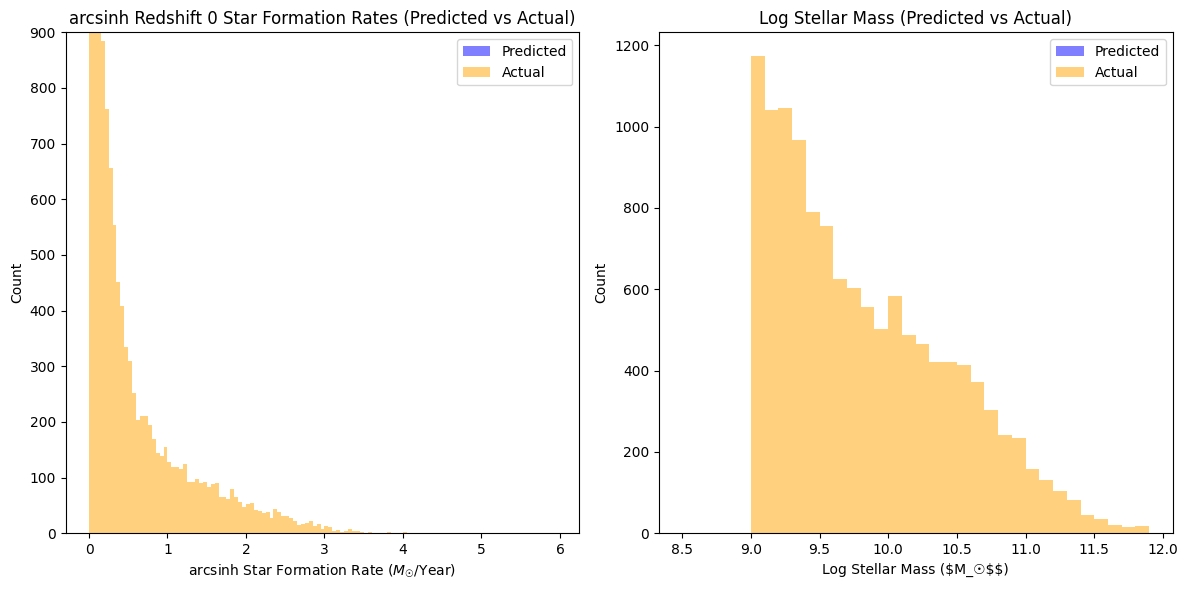

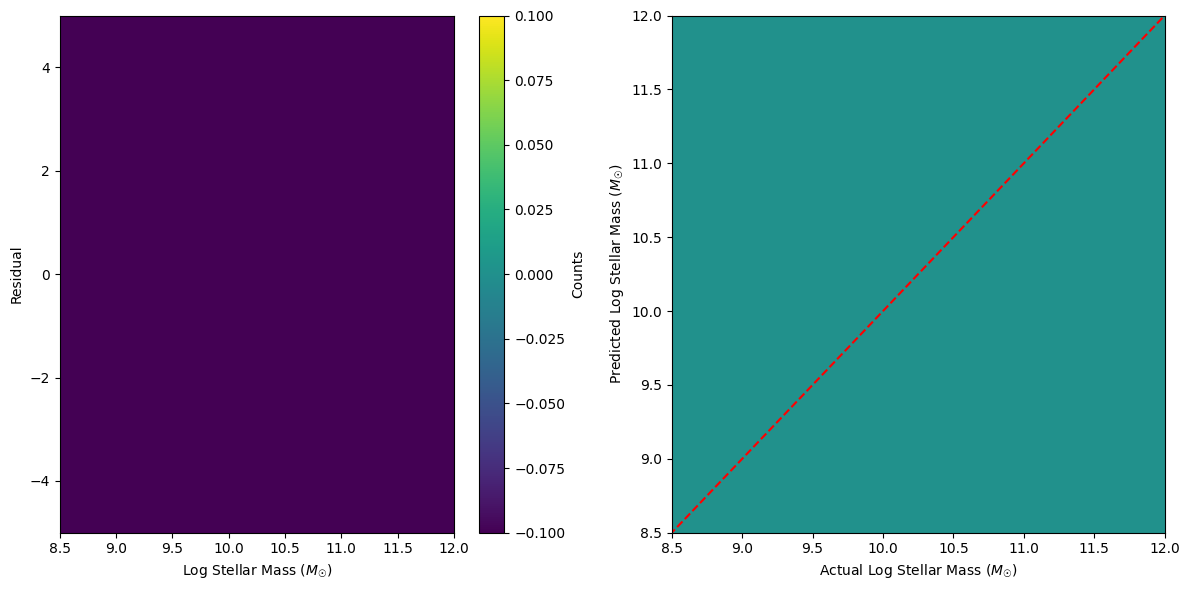

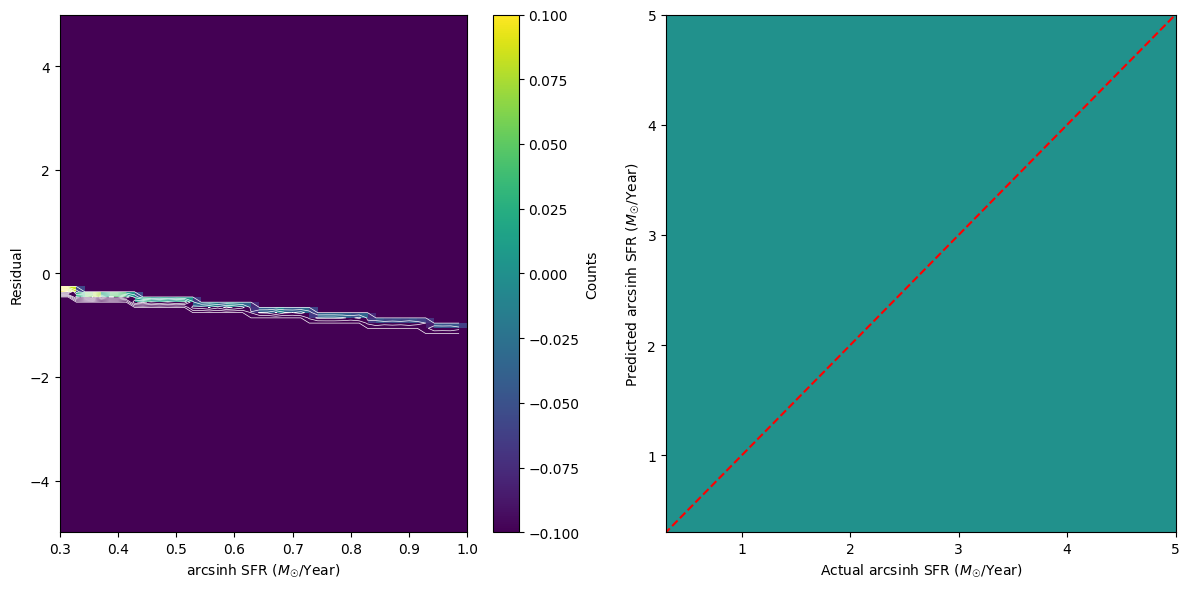

/var/folders/xp/6swc9ryd7dd18jw236kls_kw0000gn/T/ipykernel_84929/568215999.py:94: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax[1].set_yscale('log')


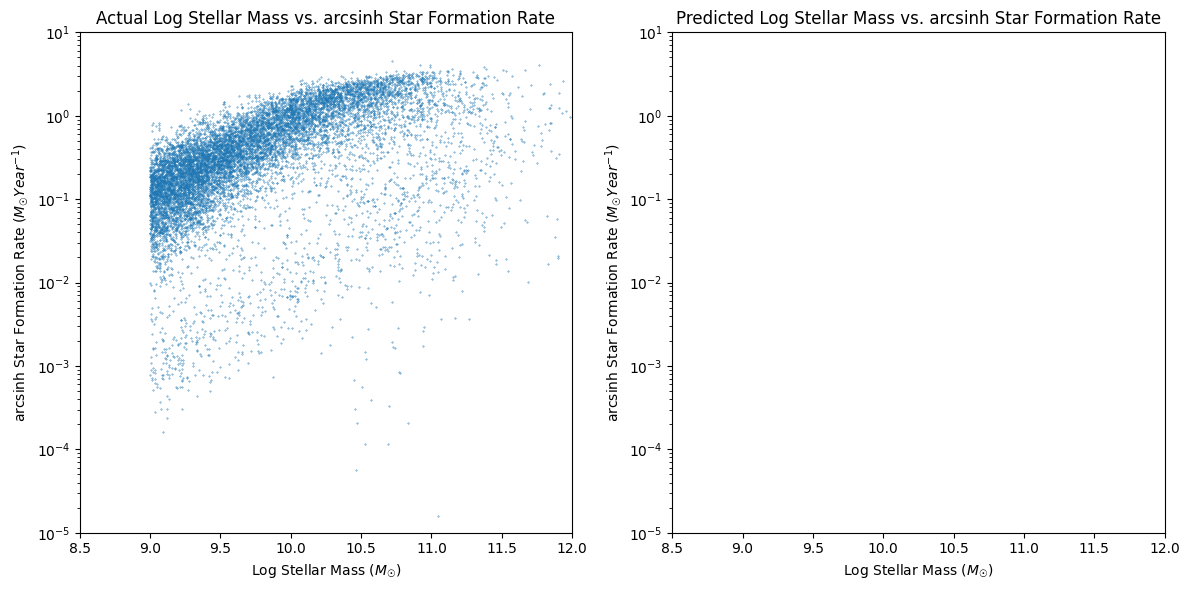

In [16]:
pred_actual_data_vis(pred_mass, pred_sfr, stellar_mass, star_formation_rate)

In [12]:
def r2_score(y_true, y_pred):
    ss_res = torch.sum((y_true - y_pred) ** 2)
    ss_tot = torch.sum((y_true - torch.mean(y_true)) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2.item()

In [13]:
def pred_actual_data_vis(pred_mass, pred_sfr, stellar_mass, star_formation_rate):
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # Plot the first set of histograms on the first subplot
    ax[0].hist(pred_sfr, bins=np.arange(0, 6, 0.05), alpha=0.5, label='Predicted', color='blue')
    ax[0].hist(star_formation_rate, bins=np.arange(0, 6, 0.05), alpha=0.5, label='Actual', color='orange')
    ax[0].set_xlabel('arcsinh Star Formation Rate ($M_\u2609$/Year)')
    ax[0].set_ylabel('Count')
    ax[0].set_ylim(0, 900)
    ax[0].set_title('arcsinh Redshift 0 Star Formation Rates (Predicted vs Actual)')
    ax[0].legend()
    
    # Plot the second set of histograms on the second subplot
    ax[1].hist(pred_mass, bins=np.arange(8.5, 12, 0.1), alpha=0.5, label='Predicted', color='blue')
    ax[1].hist(stellar_mass, bins=np.arange(8.5, 12, 0.1), alpha=0.5, label='Actual', color='orange')
    ax[1].set_xlabel('Log Stellar Mass ($M_\u2609$$)')
    ax[1].set_ylabel('Count')
    ax[1].set_title('Log Stellar Mass (Predicted vs Actual)')
    ax[1].legend()
    
    # Display the plots
    plt.tight_layout()
    plt.show()
    
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # First plot (2D Histogram of Stellar Mass vs Residuals)
    hist = ax[0].hist2d(stellar_mass, pred_mass - stellar_mass, bins=[np.linspace(5, 12, 100), np.linspace(-5, 5, 100)])
    ax[0].set_xlabel('Log Stellar Mass ($M_\u2609$)')
    ax[0].set_ylabel('Residual')
    ax[0].set_ylim(-5, 5)
    ax[0].set_xlim(8.5, 12)
    
    X, Y = np.meshgrid(np.linspace(5, 12, 100), np.linspace(-5, 5, 100))
    ax[0].contour(X[:-1, :-1] + np.diff(X[:2, 0]) / 2.,
                  Y[:-1, :-1] + np.diff(Y[0, :2]) / 2., hist[0].T, levels=6, colors='w', linewidths=0.5)
    
    hist = ax[1].hist2d(stellar_mass, pred_mass, bins=[np.linspace(5, 12, 500), np.linspace(5, 12, 500)])
    ax[1].set_xlabel('Actual Log Stellar Mass ($M_\u2609$)')
    ax[1].set_ylabel('Predicted Log Stellar Mass ($M_\u2609$)')
    ax[1].set_ylim(8.5, 12)
    ax[1].set_xlim(8.5, 12)
    ax[1].plot(x, x, color='red', linestyle='--', label='y=x')
    cbar = plt.colorbar(hist[3], ax=ax[0])
    cbar.set_label('Counts')
    
    
    # Display the plots
    plt.tight_layout()
    plt.show()
    
    # Create a figure with two subplots
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    
    # First plot (2D Histogram of Stellar Mass vs Residuals)
    hist = ax[0].hist2d(star_formation_rate, pred_sfr - star_formation_rate, bins=[np.linspace(0.3, 1, 50), np.linspace(-5, 5, 100)])
    ax[0].set_xlabel('arcsinh SFR ($M_\u2609$/Year)')
    ax[0].set_xlim(0.3,1)
    ax[0].set_ylabel('Residual')
    
    X, Y = np.meshgrid(np.linspace(0.3, 1, 50), np.linspace(-5, 5, 100))
    ax[0].contour(X[:-1, :-1] + np.diff(X[:2, 0]) / 2.,
                  Y[:-1, :-1] + np.diff(Y[0, :2]) / 2., hist[0].T, levels=6, colors='w', linewidths=0.5)
    
    hist = ax[1].hist2d(star_formation_rate, pred_sfr, bins=[np.linspace(0.3, 5, 100), np.linspace(0.3, 5, 100)])
    ax[1].set_xlabel('Actual arcsinh SFR ($M_\u2609$/Year)')
    ax[1].set_ylabel('Predicted arcsinh SFR ($M_\u2609$/Year)')
    ax[1].set_xlim(0.3,5)
    ax[1].set_ylim(0.3,5)
    ax[1].plot(x, x, color='red', linestyle='--', label='y=x')
    cbar = plt.colorbar(hist[3], ax=ax[0])
    cbar.set_label('Counts')
    
    
    # Display the plots
    plt.tight_layout()
    plt.show()

    fig, ax = plt.subplots(1, 2, figsize=(12, 6))

    # First plot (Actual Log Stellar Mass vs. arcsinh Star Formation Rate)
    ax[0].scatter(stellar_mass, star_formation_rate, s=0.1, alpha=1)
    ax[0].set_yscale('log')
    ax[0].set_xlim(8.5, 12)
    ax[0].set_ylim(1e-5, 10)
    ax[0].set_xlabel('Log Stellar Mass ($M_\u2609$)')
    ax[0].set_ylabel('arcsinh Star Formation Rate ($M_\u2609 Year^{-1}$)')
    ax[0].set_title('Actual Log Stellar Mass vs. arcsinh Star Formation Rate')
    
    # Second plot (Predicted Log Stellar Mass vs. arcsinh Star Formation Rate)
    ax[1].scatter(pred_mass, pred_sfr, s=0.1, alpha=1)
    ax[1].set_yscale('log')
    ax[1].set_xlim(8.5, 12)
    ax[1].set_ylim(1e-5, 10)
    ax[1].set_xlabel('Log Stellar Mass ($M_\u2609$)')
    ax[1].set_ylabel('arcsinh Star Formation Rate ($M_\u2609 Year^{-1}$)')
    ax[1].set_title('Predicted Log Stellar Mass vs. arcsinh Star Formation Rate')
    
    # Display the plots
    plt.tight_layout()
    plt.show()

In [14]:
def pred_actual_data_eval(pred_mass, pred_sfr, stellar_mass, star_formation_rate):
    r_squared_mass = r2_score(stellar_mass, pred_mass)
    r_squared_sfr = r2_score(star_formation_rate, pred_sfr)
    print(f'Score for log stellar mass: {r_squared_mass}\nScore for arcsinh SFR: {r_squared_sfr}')

    baseline_pred_mass = torch.tensor(np.full(len(stellar_mass), torch.mean(stellar_mass)))
    baseline_pred_sfr = torch.tensor(np.full(len(star_formation_rate), torch.mean(star_formation_rate)))
    print(f'\nRMSE for Stellar Mass: {torch.sqrt(torch.mean((pred_mass - stellar_mass)**2))} \nRMSE for SFR: {torch.sqrt(torch.mean((pred_sfr - star_formation_rate)**2))}') #Root mean squared error
    print(f'\nBaseline RMSE for Stellar Mass: {torch.sqrt(torch.mean((baseline_pred_mass - stellar_mass)**2))} (Predicting the mean) \nBaseline RMSE for SFR: {torch.sqrt(torch.mean((baseline_pred_sfr - star_formation_rate)**2))} (Predicting the mean)') #Root mean squared error

    print(f'\n1,5,10,50,90,95,99 Percentiles for mass residuals: {np.percentile(pred_mass - stellar_mass,[1,5,10,50,90,95,99])}') # Residual percentiles
    print(f'\n1,5,10,50,90,95,99 Percentiles for SFR residuals: {np.percentile(pred_sfr - star_formation_rate,[1,5,10,50,90,95,99])}') # Residual percentiles